# Causal Lasso

This notebook provides a quick code demo for "A Bregman Method for Structure Learning on Sparse Directed Acyclic Graphs"

In [595]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from graph_tools.data_gen import gen_graph, sample_lin_scms
from causal_lasso.solver import CLSolver
from graph_tools.metrics import compare_graphs

In [596]:
import graph_tools
graph_tools.__file__

'/Users/manonromain/Documents/Bregman_DAG/graph_tools/__init__.py'

### Synthetic graph generation 

We generate a synthetic graph $G$ (here a Scale-Free graph with 50 nodes). 

In [597]:
graph_type = "scale-free" # choose between "scale-free" and "erdos-renyi"
n = 20 # number of nodes
G, adj_matrix = gen_graph(graph_type, n, mean_deg=4)

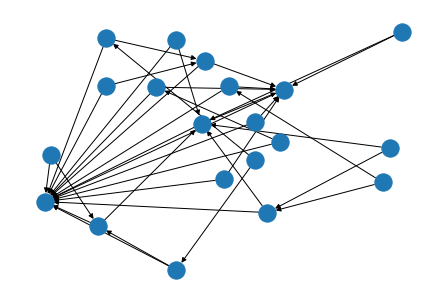

In [598]:
nx.draw(G)

### Synthetic data generation

We sample a weighted adjacency matrix `w_opt` and $m=1000$ i.i.d. samples distributed according to the SCM:

$$X = XW^* + E$$

where $X\in\mathbb{R}^{m\times n}$ is the sample matrix, $W^*\in\mathbb{R}^{n\times n}$ is the adjacency matrix of graph $G$ and $E \sim^{\text{i.i.d.}} \exp(1)$ (resp. $\mathcal{N}(0, 1)$ or $\mathrm{Gumbel}(0, 1)$)

In [599]:
noise_type = "gaussian" # or "gumbel" or "exp"
nb_samples = 1000
X, w_opt, _ = sample_lin_scms(graph_type, noise_type, adj_matrix, nb_samples=nb_samples, weighted=True)

## Learning

In [600]:
np.sum(w_opt**2) 

61.58012127707585

In [674]:
import importlib
import causal_lasso.solver as solver
from types import ModuleType

def rreload(module, d=1):
    """Recursively reload modules."""
    if d:
        for attribute_name in dir(module):
            attribute = getattr(module, attribute_name)
            if type(attribute) is ModuleType:
                rreload(attribute, d=d-1)
    print("Reloading", module)
    importlib.reload(module)
rreload(solver, d=1)
CLSolver = solver.CLSolver

Reloading <module 'causal_lasso.general_weights_algo' from '/Users/manonromain/Documents/Bregman_DAG/causal_lasso/general_weights_algo.py'>
Reloading <module 'numpy' from '/Users/manonromain/miniconda3/lib/python3.8/site-packages/numpy/__init__.py'>
Reloading <module 'causal_lasso.positive_weights_algo' from '/Users/manonromain/Documents/Bregman_DAG/causal_lasso/positive_weights_algo.py'>
Reloading <module 'torch' from '/Users/manonromain/miniconda3/lib/python3.8/site-packages/torch/__init__.py'>
Reloading <module 'causal_lasso.solver' from '/Users/manonromain/Documents/Bregman_DAG/causal_lasso/solver.py'>


We now use our algorithm to recover the weighted adjacency matrix from $X$.

In [675]:
# import cProfile
# cp = cProfile.Profile()
# cp.enable()
l1_pen_list =  [0, 1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4]
#for l1_pen in l1_pen_list:
algs, sols, results = {}, {}, {}

In [678]:

for version in ["init_progdag_unnorm"]:#, "init_progdag_unnorm", "init_progdag_normed", "random_progdag_unnorm"]:
    init_without_dag = version.startswith("init")
    X_ = X
    if version.endswith("normed"):
        X_ -= np.mean(X, axis=0, keepdims=True)
    s = np.random.randint(10)
    np.random.seed(s)
    alg = CLSolver(version="gen", dagness_exp=1e-1, dagness_pen=1e1, l1_pen=1e-2, eps=1e-10, max_iter=100,
                   logging=True, solver="mosek", init_without_dag=init_without_dag)

    Wk = alg.fit(X_)
    _, _, _, _, shd = compare_graphs(adj_matrix, np.abs(Wk)>=0.5)
    algs[version] = alg
    sols[version] = Wk
    results[version] = shd


Previous solution satifies assump True True True True
MSK - Value after: 7.141102815614431
Value before= 7.140376533437568
g= 7.140483496329488
trf= -0.0002889045590486053
kern= -1306.5026279447254
Previous solution satifies assump True True True True
MSK - Value after: 7.140938661250402
Value before= 7.140483496329488
g= 7.140486655179843
trf= -0.0002922097359575007
kern= -1306.4410146234973
Previous solution satifies assump True True True True
MSK - Value after: 7.14114277283079
Value before= 7.140486655179843
g= 7.14048918030076
trf= -0.0002915900635204974
kern= -1306.379805053429
Previous solution satifies assump True True True True
MSK - Value after: 7.140609070600476
Value before= 7.14048918030076
g= 7.140392672685364
trf= -0.0002859351993373584
kern= -1306.334977816093
Previous solution satifies assump True True True True
MSK - Value after: 7.140169666658039
Value before= 7.140392672685364
g= 7.140247964420603
trf= -0.00028638788792321903
kern= -1306.2872693858092
Previous solut

AssertionError: (7.140534604226779, -0.00028773270304960775, 0.00015646515597230368, 7.140403336679702, '<=', 7.140306231203967)

In [651]:
def dichotomy_thres_(W, elems):
    m = len(elems)
    if m<=2:
        a = np.max(elems)
        W_thres = W.copy()
        W_thres[W_thres<=a] = 0
        return W_thres
    med = elems[m//2]
    W_thres = W.copy()
    W_thres[W_thres<=med] = 0
    if np.trace(np.linalg.matrix_power(W_thres + np.eye(n), n)) > n:
        return dichotomy_thres_(W, elems[:(m//2+1)])
    else:
        return dichotomy_thres_(W, elems[(m//2):])
    
def dichotomy_thres(W):
    W_thr = dichotomy_thres_(W, np.sort(W[W>0].flatten())[::-1]) 
    W_thr[W_thr>0] = 1
    return W_thr

In [652]:
Wk_thres = Wk.copy()
Wk_thres = dichotomy_thres(Wk)
print(np.trace(np.linalg.matrix_power(Wk + np.eye(n), n)))
print(np.trace(np.linalg.matrix_power(Wk_thres +np.eye(n), n)))

39606.60617581151
20.0


In [653]:
import cdt
cdt.metrics.SHD(Wk_thres, adj_matrix)

38.0

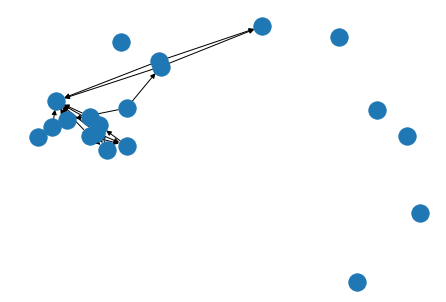

In [659]:
nx.draw(nx.DiGraph(Wk_thres))

In [660]:
# plt.plot(l1_pen_list, results, label="ours$^{+}$")
# plt.plot(l1_pen_list, results_notears, label="notears")
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()

In [661]:
compare_graphs(adj_matrix, np.abs(Wk_thres)>=0.3)
#results.append(shd)

Number of edges in ground truth graph 37.0
Number of edges in estimation 19
Correct edges 9.0
Reversed edges 1.0
Missing edges 27.0
Extra edges 9.0
SHD 37.0


(9.0, 9.0, 1.0, 27.0, 37.0)

In [662]:
# import pstats #, StringIO
# #s = StringIO.StringIO()
# sortby = 'tottime'
# ps = pstats.Stats(cp).sort_stats(sortby)
# ps.print_stats()

<AxesSubplot:>

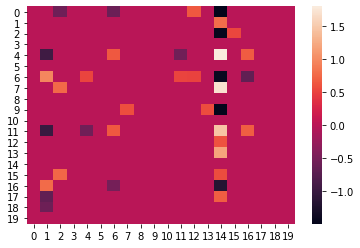

In [663]:
sns.heatmap(Wk)

#### NOTEARS

To run NOTEARS, download the repository from https://github.com/xunzheng/notears in the same folder as this notebook. 

In [199]:
# Importing no tears if in parent folder
try:
    import os,sys,inspect
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 

    from notears.notears.linear import notears_linear
    run_notears = True
except ImportError:
    run_notears = False

In [200]:
if run_notears:
    results_notears = []
    W_notears, log_dict_notears = notears_linear(X, 1e-1, "l2")
    _, _, _, _, shd = compare_graphs(adj_matrix, np.abs(W_notears))
    results_notears.append(shd)






Number of edges in ground truth graph 37.0
Number of edges in estimation 37
Correct edges 37.0
Reversed edges 0.0
Missing edges 0.0
Extra edges 0.0
SHD 0.0


In [201]:
import cdt
print(cdt.metrics.SHD(adj_matrix, np.abs(W_notears)>0))
print(cdt.metrics.SHD(adj_matrix, np.abs(Wk)>0))

0.0
37.0


In [202]:
_, _, _, _, shd = compare_graphs(adj_matrix, np.abs(W_notears))

Number of edges in ground truth graph 37.0
Number of edges in estimation 37
Correct edges 37.0
Reversed edges 0.0
Missing edges 0.0
Extra edges 0.0
SHD 0.0


## Extra visualisations

We provide extra visualisations that could be of interest to the reader. The first one shows convergence of different part of the objective with iteration of our algorithm. 

In [614]:
logging = alg.log_dict
log_dict_notears = {k:np.array(v) for k,v in log_dict_notears.items()}

In [615]:
Wk

array([[0.96058957, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.97270345, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.97252372, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.97321386, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

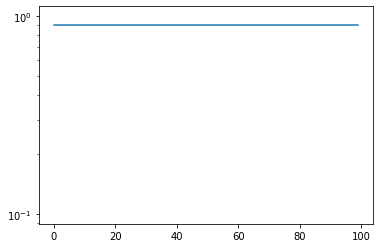

In [616]:
plt.plot(alg.log_dict["gammas"])
plt.yscale("log")

In [617]:
print(dict_to_plot)

{'init_progdag_unnorm': {'dagness_exp': array(1), 'dagness_pen': array(0.01), 'l1_pen': array(0), 'time': array([  1.34828472,   2.67781591,   4.02423382,   5.45171976,
         6.87556291,   8.33625197,   9.76649499,  11.21303487,
        12.68637681,  14.15290785,  15.63749909,  17.05494189,
        18.52420402,  20.02186203,  21.51541972,  23.01840997,
        24.51333404,  25.97649717,  27.45738101,  29.00848985,
        30.55236983,  32.06284475,  33.63673902,  35.20648003,
        36.8105309 ,  38.37751007,  39.9021759 ,  41.46916986,
        43.05103993,  44.59230304,  46.1335969 ,  47.69632411,
        49.31253695,  50.91169786,  52.48166013,  54.05288005,
        55.62546301,  57.17979312,  58.73460078,  60.33118105,
        62.01771688,  63.67865896,  65.28234887,  66.87509704,
        68.54008484,  70.21543002,  71.86687303,  73.48071384,
        75.11503196,  76.7886498 ,  78.46731496,  80.06576991,
        81.68498182,  83.30211401,  84.95120287,  86.56502175,
        88.1

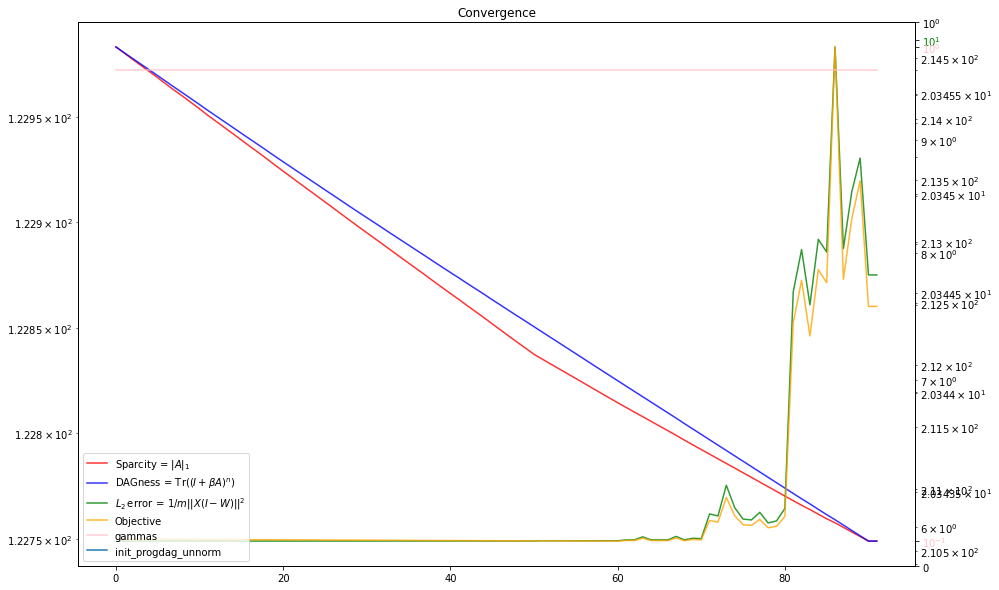

In [666]:
dict_to_plot = {v:alg.log_dict for v, alg in algs.items() if "progdag" in v}
sols_to_plot = {v:alg.sol for v, alg in algs.items() if "progdag" in v}

from matplotlib.lines import Line2D


def plot_dict(dict_to_plot, sols_to_plot):
    metrics = ["l2error", "dagness", "l1pen", "gammas", "obj"]
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 
                  (0, (3, 5, 1, 5)),(0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),
                 (0, (5, 10)),(0, (5, 1))]
    colors = ["red", "blue", "green", "orange", "black", "pink"]
    hlines = False
    fig, ax1 = plt.subplots(figsize=(15,10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    ax5 = ax1.twinx()
    ax6 = ax1.twinx()
    lgd_lines, lgd_labels = [], []
    for k, version in enumerate(dict_to_plot):
        log_dict = dict_to_plot[version]
        w = alg.sol
        linestyle = linestyles[k]
        
        
        l1pen_final = np.sum(np.abs(w))
        l2error_final = 1/nb_samples*np.linalg.norm(X@(np.eye(n)-w), "fro")**2
        dagness_final = np.trace(np.linalg.matrix_power(np.eye(n) + np.abs(w), n))
        obj_final = l2error_final + log_dict["dagness_pen"] * dagness_final + log_dict["l1_pen"] * l1pen_final
        values_l2error = log_dict["l2_error"] * (2 if version=="notears" else 1) #FIXME
        values_l1pen = log_dict["l1_val"]
        values_dagness = log_dict["dag_constraint"]
        values_obj = values_l2error + log_dict["dagness_pen"] * values_dagness + log_dict["l1_pen"] * values_l1pen

        if version != "notears":
            values_change_support = log_dict["nb_change_support"]

        if "l1pen" in metrics:
            l1, = ax1.plot(values_l1pen, linestyle=linestyle,alpha=0.8, color=colors[0])
            if not k:
                lgd_lines.append(l1)
                lgd_labels.append("Sparcity = $\|A\|_1$")
            if hlines:
                ax1.hlines(l1pen_final, 0, 100, 
                           colors=colors[0], linestyles=linestyle)
        
        if "dagness" in metrics:
            l2, = ax2.plot(values_dagness, linestyle=linestyle, alpha=0.8,color=colors[1])
            if not k:
                lgd_lines.append(l2)
                lgd_labels.append("DAGness = $\mathrm{Tr}((I+\\beta A)^n)$")
            if hlines:
                ax2.hlines(dagness_final, 0, 100, 
                           colors=colors[1], linestyles=linestyle)
        
        if "l2error" in metrics:    
            l3, = ax3.plot(values_l2error, linestyle=linestyle,alpha=0.8, color=colors[2])
            if not k:
                lgd_lines.append(l3)
                lgd_labels.append("$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$")
            if hlines:
                ax3.hlines(l2error_final, 0, 100, 
                           colors=colors[2], linestyles=linestyle)
            
        if "obj" in metrics:   
            l4, = ax4.plot(values_obj, linestyle=linestyle, alpha=0.8, color=colors[3])
            if not k:
                lgd_lines.append(l4)
                lgd_labels.append("Objective")
            if hlines:
                ax4.hlines(obj_final, 0, 100, 
                           colors=colors[3], linestyles=linestyle)
            
        if "change_support" in metrics and version != "notears":  
            l5, = ax5.plot(values_change_support, linestyle=linestyle, alpha=0.8, color=colors[4])
            if not k:
                lgd_lines.append(l5)
                lgd_labels.append("Nb change support")
                
        if "gammas" in metrics and version != "notears":  
            l6, = ax6.plot(log_dict["gammas"], linestyle=linestyle, alpha=0.8, color=colors[5])
            if not k:
                lgd_lines.append(l6)
                lgd_labels.append("gammas")
                
                
        
        lgd_lines.append(Line2D([0], [0], linestyle=linestyle))
        lgd_labels.append(version)

            
          
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.set_yscale("log")
    ax2.tick_params(axis='y', labelcolor=colors[1])
    ax2.set_yscale("log")
    ax3.tick_params(axis='y', labelcolor=colors[2])
    ax3.set_yscale("log")
    ax4.tick_params(axis='y', labelcolor=colors[3])
    ax4.set_yscale("log")
    ax5.tick_params(axis='y', labelcolor=colors[4])
    ax5.set_yscale("symlog")
    ax6.tick_params(axis='y', labelcolor=colors[5])
    ax6.set_yscale("log")
            
    plt.legend(lgd_lines, lgd_labels)
    plt.title("Convergence");
    #plt.xlim([20, None])



plot_dict(dict_to_plot, sols_to_plot)

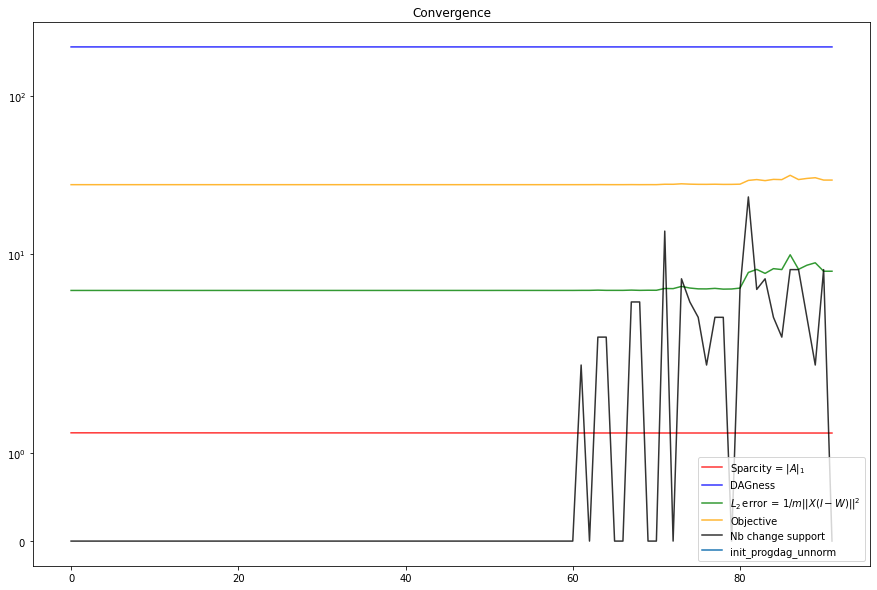

In [665]:
dict_to_plot = {v:alg.log_dict for v, alg in algs.items() if "progdag" in v}
sols_to_plot = {v:alg.sol for v, alg in algs.items() if "progdag" in v}

from matplotlib.lines import Line2D


def plot_dict_onsameplot(dict_to_plot, sols_to_plot):
    metrics = ["l2error", "change_support", "dagness", "l1pen", "gamma", "obj"]
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 
                  (0, (3, 5, 1, 5)),(0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),
                 (0, (5, 10)),(0, (5, 1))]
    colors = ["red", "blue", "green", "orange", "black"]
    hlines = False
    fig = plt.figure(figsize=(15,10))
    lgd_lines, lgd_labels = [], []
    for k, version in enumerate(dict_to_plot):
        log_dict = dict_to_plot[version]
        w = alg.sol
        linestyle = linestyles[k]
        
        
        l1pen_final = np.sum(np.abs(w))
        l2error_final = 1/nb_samples*np.linalg.norm(X@(np.eye(n)-w), "fro")**2
        dagness_final = np.trace(np.linalg.matrix_power(np.eye(n) + np.abs(w), n))
        obj_final = l2error_final + log_dict["dagness_pen"] * dagness_final + log_dict["l1_pen"] * l1pen_final
        values_l2error = log_dict["l2_error"] * (2 if version=="notears" else 1) #FIXME
        values_l1pen = log_dict["l1_val"]
        values_dagness = log_dict["dag_constraint"]
        values_obj = values_l2error + values_dagness + log_dict["l1_pen"] * values_l1pen

        if version != "notears":
            values_change_support = log_dict["nb_change_support"]

        if "l1pen" in metrics:
            l1, = plt.plot(log_dict["l1_pen"] * values_l1pen, linestyle=linestyle,alpha=0.8, color=colors[0])
            if not k:
                lgd_lines.append(l1)
                lgd_labels.append("Sparcity = $\|A\|_1$")
            if hlines:
                plt.hlines(l1pen_final, 0, 100, 
                           colors=colors[0], linestyles=linestyle)
        
        if "dagness" in metrics:
            l2, = plt.plot(log_dict["dagness_pen"] * values_dagness, linestyle=linestyle, alpha=0.8,color=colors[1])
            if not k:
                lgd_lines.append(l2)
                lgd_labels.append("DAGness")
            if hlines:
                plt.hlines(dagness_final, 0, 100, 
                           colors=colors[1], linestyles=linestyle)
        
        if "l2error" in metrics:    
            l3, = plt.plot(values_l2error, linestyle=linestyle,alpha=0.8, color=colors[2])
            if not k:
                lgd_lines.append(l3)
                lgd_labels.append("$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$")
            if hlines:
                plt.hlines(l2error_final, 0, 100, 
                           colors=colors[2], linestyles=linestyle)
            
        if "obj" in metrics:   
            l4, = plt.plot(values_obj, linestyle=linestyle, alpha=0.8, color=colors[3])
            if not k:
                lgd_lines.append(l4)
                lgd_labels.append("Objective")
            if hlines:
                plt.hlines(obj_final, 0, 100, 
                           colors=colors[3], linestyles=linestyle)
            
        if "change_support" in metrics and version != "notears":  
            l5, = plt.plot(values_change_support, linestyle=linestyle, alpha=0.8, color=colors[4])
            if not k:
                lgd_lines.append(l5)
                lgd_labels.append("Nb change support")
        
        lgd_lines.append(Line2D([0], [0], linestyle=linestyle))
        lgd_labels.append(version)

            
          
    
    plt.yscale("symlog")
    plt.legend(lgd_lines, lgd_labels)
    plt.title("Convergence");
   #plt.xlim([20, None])



plot_dict_onsameplot(dict_to_plot, sols_to_plot)

In [154]:
lgd_lines

NameError: name 'lgd_lines' is not defined

In [155]:
len(dict_to_plot)

1

In [156]:
times = logging["time"]
times_notears = log_dict_notears["time"]
values_l2error = logging["l2_error"]
values_l2error_notears = log_dict_notears["l2_error"] - n
l2error_notears = 1/1000*np.linalg.norm(X@(np.eye(n)-W_notears))**2
l2error_ours = 1/1000*np.linalg.norm(X@(np.eye(n)-Wk))**2
l2error_opt = 1/1000*np.linalg.norm(X@(np.eye(n)-w_opt))**2
values_l1pen = logging["l1_val"] 
values_l1pen_notears = log_dict_notears["l1_val"] 
l1pen_notears = np.sum(np.abs(W_notears))
l1pen_ours = np.sum(np.abs(Wk))
l1pen_opt = np.sum(np.abs(w_opt))
values_dagness = logging["dag_constraint"]
values_dagness_notears = log_dict_notears["dag_constraint"] + n
dagness_notears = np.trace(np.linalg.matrix_power(np.eye(n) + logging["dagness_exp"] * np.abs(W_notears), n))
dagness_ours = np.trace(np.linalg.matrix_power(np.eye(n) + logging["dagness_exp"] * np.abs(Wk), n))
dagness_opt = np.trace(np.linalg.matrix_power(np.eye(n) + logging["dagness_exp"] * np.abs(w_opt), n))
values_obj = values_l2error + logging["dagness_pen"] * values_dagness + logging["l1_pen"] * values_l1pen
values_obj_notears = values_l2error_notears + values_dagness_notears + log_dict_notears["l1_pen"] * values_l1pen_notears
obj_notears = l2error_notears + logging["dagness_pen"] * dagness_notears + logging["l1_pen"] * l1pen_notears
obj_ours = l2error_ours + logging["dagness_pen"] * dagness_ours + logging["l1_pen"] * l1pen_ours
obj_opt = l2error_opt + logging["dagness_pen"] * dagness_opt + logging["l1_pen"] * l1pen_opt
logging["obj"] = values_obj
values_change_support = logging["nb_change_support"]

hlines = False

fig, ax1 = plt.subplots(figsize=(15,10))

# color = 'tab:red'
# l1 = ax1.plot(values_l1pen, label = "Sparcity = $\|A\|_1$", color=color)
# ax1.plot(values_l1pen_notears, "--", color=color)
# if hlines:
#     ax1.hlines([l1pen_notears, l1pen_ours, l1pen_opt], 0, 100, 
#                colors=[color], linestyles=["dashed", "dashdot", "dotted"])
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
l2 = ax2.plot(times, values_dagness, "-.-", label="DAGness = $\mathrm{Tr}((I+\\beta A)^n)$", color=color)
ax2.plot(times_notears, values_dagness_notears, "--", color=color)
if hlines:
    ax2.hlines([dagness_notears, dagness_ours, dagness_opt], 0, 100, 
               colors=[color], linestyles=["dashed", "dashdot", "dotted"])
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")

# ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:green'
# l3 = ax3.plot(values_l2error, color=color, label='$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$')
# ax3.plot(values_l2error_notears, "--", color=color)
# if hlines:
#     ax3.hlines([l2error_notears, l2error_ours, l2error_opt], 0, 100, 
#                colors=[color], linestyles=["dashed", "dashdot", "dotted"])
# ax3.tick_params(axis='y', labelcolor=color)
# ax3.set_yscale("log")

# ax4 = ax1.twinx()
# color = 'tab:grey'
# l4 = ax4.plot(values_obj, color=color, label='Objective = $f(x)+g(x)$')
# ax4.hlines([obj_notears, obj_ours, obj_opt], 0, 100, 
#            colors=['grey'], linestyles=["dashed", "dashdot", "dotted"])
# ax4.tick_params(axis='y', labelcolor=color)
# ax4.set_yscale("log")

# ax5 = ax1.twinx()
# color = 'tab:pink'
# l5 = ax5.plot(values_change_support, color=color, label='Number of changes in support')
# ax5.tick_params(axis='y', labelcolor=color)
# ax5.set_yscale("log")

lines = l1 + l2 + l3 #+ l4 # + l5
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, ncol=2,  bbox_to_anchor=(1, 1.4))

plt.title("$\mathrm{Ours}$ convergence");

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
dagness_notears, dagness_ours, dagness_opt

The second one is a mere visualisation of the output as a heatmap.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(w_opt, center=0, ax=axs[0]); axs[0].set_xticks([]);  axs[0].set_yticks([]); 
axs[0].set_title("Ground truth adjacency matrix");
sns.heatmap(Wk, center=0, ax=axs[1]); axs[1].set_xticks([]);  axs[1].set_yticks([]); 
axs[1].set_title("Output adjacency matrix");

The last one demonstrates the convergence of the matrix support with iterations, as we go down, our algorithm progresses towards the correct graph, the last line (light blue) being the ground truth adjacency matrix

In [ ]:
n_iter = len(logging["support"])
plt.figure(figsize=(18,5))
sns.heatmap(np.array(np.append(np.int32(logging["support"]),
                               -np.reshape(adj_matrix.flatten(), (1,n*n)), axis=0)),
           center=0, cbar=False); 
plt.xticks([]); plt.yticks(np.arange(0, n_iter+1, step=n_iter//10), np.arange(0, n_iter+1, step=n_iter//10));
plt.xlim([0, 500])
plt.title("Convergence of the support")
plt.xlabel("Coefficients of matrix 0 to 500");
plt.ylabel("Number of iterations");

Thank you!

In [101]:
from scipy.linalg import expm
n = 50
dagness_pen = 1
dagness_exp = 1e-1

def dag_penalty(W_plus, W_minus):
    sum_W = W_plus + W_minus
    return dagness_pen * np.trace(expm(dagness_exp * sum_W))

def grad_f_scalar_H(W_plus, W_minus, H_plus, H_minus):
    """ Returns <∇f(W), D> """
    sum_W = W_plus + W_minus
    sum_H = H_plus + H_minus
    expW = expm(dagness_exp * sum_W)
    return dagness_pen * dagness_exp * np.trace(expW @ sum_H)

def df(Wx_plus, Wx_minus, Wy_plus, Wy_minus):
    return dag_penalty(Wx_plus, Wx_minus) - dag_penalty(Wy_plus, Wy_minus) - \
        grad_f_scalar_H(Wy_plus, Wy_minus, Wx_plus - Wy_plus, Wx_minus - Wy_minus)

def distance_kernel(Wx_plus, Wx_minus, Wy_plus, Wy_minus):
    """
    the kernel used is e^(||W||_F**2) where
    """
    sum_x = Wx_plus + Wx_minus
    sum_y = Wy_plus + Wy_minus
    norm_y = np.linalg.norm(sum_y, "fro")
    norm_x = np.linalg.norm(sum_x, "fro")
    product = np.trace(sum_y.T @ (sum_x - sum_y))

    hWx = np.exp((dagness_exp * norm_x) ** 2)
    hWy = np.exp((dagness_exp * norm_y) ** 2)
    grad_hy_scalar_x_minus_y = 2 * dagness_exp * hWy * product
    return .5 * dagness_pen * (hWx - hWy - grad_hy_scalar_x_minus_y)

In [159]:

dfs, dhs = [], []

Wx_plus, Wx_minus, Wy_plus, Wy_minus = np.load("23_02_21_wrong_w_plus.npy"), np.load("23_02_21_wrong_w_minus.npy"),\
                                        np.load("23_02_21_wrong_wk_plus.npy"), np.load("23_02_21_wrong_wk_minus.npy")

assert np.sum(Wx_plus**2 + Wx_minus**2) >= 1/(dagness_exp**2)

dfs.append(np.abs(df(Wx_plus, Wx_minus, Wy_plus, Wy_minus)))
dhs.append(distance_kernel(Wx_plus, Wx_minus, Wy_plus, Wy_minus))

#assert dfs[-1] <= dhs[-1]

AssertionError: 

FileNotFoundError: [Errno 2] No such file or directory: 'next_W_plus.npy'

-19.69411082022382

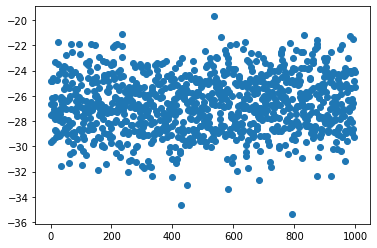

In [111]:
plt.scatter(np.arange(1000), np.array(dfs) - np.array(dhs))
np.max(np.array(dfs) - np.array(dhs))

-19.69411082022382

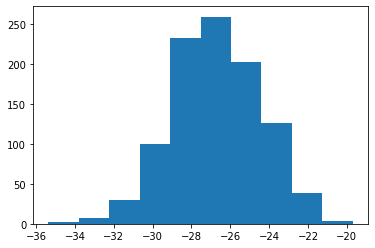

In [112]:
plt.hist(np.array(dfs) - np.array(dhs))
np.max(np.array(dfs) - np.array(dhs))